# FP auction: numerical approximation of optimal bidding

Before we start, we import the following packages which provide useful functionalities.

In [1]:
import numpy as np # all kind of vector operations; basic statistics 
                   # (mean, std); random sampling
import pandas as pd # matrix (spreadsheet-like) data structure - 
                    # useful for some calculations
from scipy import integrate # approximates functions from system of 
                            # differential equations
from scipy import stats # t-test and p-value
import matplotlib.pyplot as plt # plots
from pathlib import Path # directory functions to be able to save 
                         # plots

# Table of contents
1. [Auction Simulation](#auc_sim)
    1. [Differential equation approximation](#diff_approx)
        1. [Differential equations](#diff_eq)
        2. [Evaluation of guessed $\bar{\beta}$](#eval)
        3. [Adjustment algorithm](#adj_alg)
        4. [Approximation](#solver)
    2. [One-round simulation](#one_round)
        1. [Bids of randomly drawn valuations](#v_to_b)
            1. [cdf draws](#cdf_draw)
            2. [cdf to valuation](#cdf_value)
            3. [valuation to grid](#v_grid)
            4. [Grid-valuation to bid](#grid_to_bid)
        2. [Collecting Results](#results)
            1. [Granular results](#granular)
            2. [Aggregated results](#agg_results)
        3. [Isolated simulation](#iso_sim)
    3. [Main simulation](#main_sim)
        1. [Repeated isolated simulations](#rep_iso_sim)
        2. [Statistical results](#stat_results)
2. [Figures](#figures)
    1. [Figures of bidding strategies](#bid_plot)
    2. [Figures of one-round simulation](#one_round_plot)
        1. [50 auctions](#one_round_auction_plot)
        2. [Histogram](#one_round_dist_plot)
    3. [Figures of main simulation](#main_sim_plot)
        1. [All iterations](#main_auction_plot)
        2. [Histogram](#main_dist_plot)

# 1. Auction Simulation <a name='auc_sim'> </a>
For the derivation of PBE equilibria, we need to compare the expected prices of the $FP$ and $SP$ auction. The $FP$ auction does not have closed-form solutions for some beliefs of buyer $1$. To receive an estimate of the $FP$ expected price, we create a script that gives a numerical approximation. <br>
The script has the following structure. First, we program an algorithm that receives as inputs the system of differential equations and approximates the optimal inverse bid functions. Then we inverse the functions to the optimal bid functions and simulate 1000 auctions to receive the mean as an estimator of the expected price. Thirdly, we run the simulation 100 times to determine the standard errors (and the mean of mean prices) to be able to statistically test whether the simulated $FP$ price is significantly different from the $SP$ price.

## 1.A. Differential equation approximation <a name="diff_approx"> </a>
We approximate the inverse optimal bid functions from the system of differential equations. <br>
To achieve this, we first define the system of differential equations. Then we implement the adjustment algorithm, which brings the guess of $\bar{\beta}$ closer to the true $\bar{\beta}$. Finally, we introduce the solver, which utilizes the adjustment algorithm to receive a guessed $\bar{\beta}$ sufficiently close to the true $\bar{\beta}$. The solver returns the approximated inverse optimal bid functions.

### 1.A.a. Differential equations <a name='diff_eq'> </a>
We define the differential equations of the high-type and the low-type, each matching with the "uniform-type". <br>
The variables are defined as follows: $dxdt \equiv \phi_2^{'}$, $x \equiv \phi_2$, $y \equiv \phi_1$, and $t \equiv b$. 
Note that the differences in the equations of the different types come from dividing $F_{type}(\cdot)$ by $f_{type}(\cdot)$ which have different functional forms for the different beliefs about types. The system of differential equations functions have the inputs and outputs structured according to the needs of the approximation function.

In [2]:
def diff_eq_high(t, z): 
    x, y = z
    dxdt = 1 / (y-t) * (x / 1)
    dydt = 1 / (x-t) * (0.5*y + 0.5*y**2) / (0.5 + y)
    return [dxdt, dydt]

def diff_eq_low(t, z):
    x, y = z
    dxdt = 1 / (y-t) * (x / 1)
    dydt = 1 / (x-t) * (1.5*y - 0.5*y**2) / (1.5 - y)
    return [dxdt, dydt]

### 1.A.b Evaluation of guessed $\bar{\beta}$ <a name='eval'> </a>
The evaluation algorithm determines whether the guessed $\bar{b}$ is sufficiently close to its true value or needs an adjustment. The direction of the adjustment, if any is needed, is then returned. <br>
The function receives as inputs the valuation and bid vectors generated by the difference equation estimator and whether the estimation was successful. <br>
The ivp-algorithm (initial-value problem; the algorithm is provided by the scipy package) fails to return an approximation, if it reaches singularities or diverges. This happens if $\bar{b}$ is too large. A crossing of the 45° line also implies that the guessed $\bar{b}$ is too large. If the last estimated $v_i$ (at $b=0$) is larger than zero, it implies that $\bar{b}$ is too low. If non of the condition fails, the guessed $\bar{b}$ is sufficiently close to its true value and the approximation of the inverse optimal bid function is adequate.

In [3]:
def fct_evaluation(b, v, success_ivp):
    
    # We do not use the if - elif structure, because we would need to 
    # calculate v_crossing and v0_large in the beginning. This would 
    # be inefficient and might fail if success_ivp is False and the 
    # algorithm did not return complete arrys for v and b. Therefore, 
    # we nest the if statements.
    
    # acceptable deviation from phi(0)=0
    epsilon = 0.01
    
    # approximation failed
    if success_ivp is False:
        b_bar_deviation = 'above'
    
    else:
        # crossing of the 45° line
        v_crossing_1 = (b > v[0]).any() 
            # compares each value of the same position of the b and 
            # v vector. If any b is larger than the accompaning v, 
            # then there exists a crossing.
        v_crossing_2 = (b > v[1]).any()
        if (v_crossing_1) or (v_crossing_2):
            b_bar_deviation = 'above'
        
        else:
            # the last estimated v (at b=0) being larger than 0
            v0_large_1 = v[0][-1] > epsilon 
                # compares the last v (the closest to 0) with the 
                # epsilon.
            v0_large_2 = v[1][-1] > epsilon
            if v0_large_1 or v0_large_2:
                b_bar_deviation = 'below'

            # non of the conditions failed
            else:
                b_bar_deviation = 'sufficiently_small'
    
    return b_bar_deviation

### 1.A.c. Adjustment algorithm <a name='adj_alg'> </a>
The adjustment algorithm updates the $\bar{b}$ guess. <br>
It receives as an argument whether the guessed $\bar{b}$ should be increased or decreased. We use the bisection method for the update. It is not the most efficient method but it is sufficiently fast for our purposes and intuitive to implement.

In [4]:
def fct_adjustment(b_bar_deviation, b_bar_history):
    
    # latest b_bar guess 
    latest_b_bar = b_bar_history[-1]
    
    # adjustment magnitude is the half difference of the lastest 
    # two guesses
    adjustment_size = abs(b_bar_history[-1] - b_bar_history[-2]) / 2
    
    # adjustment
    if b_bar_deviation == 'below':
        b_bar = latest_b_bar + adjustment_size
    elif b_bar_deviation == 'above':
        b_bar = latest_b_bar - adjustment_size
    elif b_bar_deviation == 'sufficiently_small':
        b_bar = latest_b_bar
        
    return b_bar

### 1.A.d. Approximation <a name='solver'> </a>
Now we numerically approximate the system differential equation by utilizing all of the above functions. <br> 
We pass the differential equation system that we approximate as argument. The function returns an evenly spaced grid of b-values and the corresponding functional values of each buyers' valuation.

In [5]:
def diff_eq_solver(diff_eq):

    # starting parameters
    b_bar = 1 / 2 
        # starting value is naive mean of intervall
    b_bar_history = [0, b_bar] 
        # history needed to adadpt adjustment size
    b_bar_deviation = 'start' 
        # non-sensical value, but needed to start the loop

    while b_bar_deviation != 'sufficiently_small':

        # part of the model that needs adjustments
        b_span = [b_bar, 0]
        b_eval = np.linspace(b_bar, 0, 1000)
        
        # compute differential equations
        sol = integrate.solve_ivp(fun=diff_eq, t_span=b_span, 
                                  y0=[1, 1], t_eval=b_eval)
            # differential equation solver - its documentation 
            # explains the functionalities well
        success_ivp = sol.success # returns whether approximation 
                                  # was successful
        b = sol.t # t of the solution returns our bids (evenly 
                  # spaced on full b interval)
        v = sol.y # y of the solution returns our valuations 
                  # (approximated inverse bid function's funtional
                  # values for b)
        
        # evaluate & adjust b_bar
        b_bar_deviation = fct_evaluation(b, v, success_ivp)
        b_bar = fct_adjustment(b_bar_deviation, b_bar_history)
        b_bar_history.append(b_bar)

    return b, v

## 1.B. One-round simulation <a name='one_round'> </a>
We simulate 1000 auctions of which we receive the mean prices and further interesting resutls as the surplus of each buyer, the win rates of each buyer, and the rate of efficient auctions. <br>
To do so, we first draw random valuations for all auctions and assign the respective bids. Secondly, we define functions to analyze the results

## 1.B.a Bids of randomly drawn valuations <a name='v_to_b'> </a>
We have the differential equations approximated by a grid of bids which have a valuation according to the respective inverse-bid functions. Exogenously, we draw valuations for many iterations which then get their bid assigned. <br>
For this, we first draw the cdf-values which we then use to assign the valuations. Next, we approximate each valuation with the nearest-grid valuation. Finally the bids are assigned to the grid valuations.

#### 1.B.a.i. cdf draws <a name='cdf_draw'> </a>
Here we draw the cdf values of each buyer.

In [6]:
# no random seed, since we need different values for each auction
def fct_draw_cdf(periods):

    cdf_1 = np.random.random(periods)
    cdf_2 = np.random.random(periods)
    cdfs = [cdf_1, cdf_2]
    
    return cdfs

#### 1.B.a.ii. cdf to valuation <a name='cdf_value'> </a>
To receive the valuation assigned to the cdf values, we need to inverse the cdf function, since
$F(v)=x \Rightarrow v = F^{-1}(x)$. The inverse cdf-functions are the following: <br>
$F_{uni}(v) = v \Rightarrow F_{uni}^{-1}(v) = v$ <br>
$F_{high}(v) = 0.5v + 0.5v^2 \Rightarrow F_{high}^{-1}(v) = -0.5 + \sqrt{0.5^2 + 2v}$ <br>
$F_{low}(v) = 1.5v - 0.5v^2 \Rightarrow F_{low}^{-1}(v) = 1.5 - \sqrt{1.5^2-2v}$

In [7]:
def fct_assign_valuation(cdfs, typ):
    
    # unpack cdf of each buyer
    cdf_0 = cdfs[0]
    cdf_1 = cdfs[1]
    
    # inverse of uniform cdf is the function itself
    draw_v_1 = cdf_0
    
    # inverse for both typs
    if typ == 'high':
        draw_v_2 = -0.5 + np.sqrt(0.5**2 + 2*cdf_1)
    elif typ == 'low':
        draw_v_2 = 1.5 - np.sqrt(1.5**2 - 2*cdf_1)
    
    drawn_valuations = np.vstack((draw_v_1, draw_v_2))
    
    return drawn_valuations

#### 1.B.a.iii. valuation to grid <a name='v_grid'> </a>
The drawn valuations from a continuous function are assigned to the closest valuations from the grid delivered by the solution of the differential equation system. 

In [8]:
def fct_match_random_with_grid(drawn_valuations, grid_valuations):

    matched_valuations = [] # list for both buyers

    for buyer, drawn_valuation in enumerate(drawn_valuations):
        grid_valuation = grid_valuations[buyer] 
            # select valuations of one buyer
        matched_valuation = [] 
            # list for each value-matching of one buyer
        
        for valuation in drawn_valuation:
            size_higher = (grid_valuation > valuation).sum() 
                # needed to find closest v from grid

            # if drawn v is smaller than smallest v. Note that due 
            # to the epsilon>0 does not have to equal 0, but can be 
            # anywhere between 0 and epsilon
            if size_higher == len(grid_valuation):
                higher = grid_valuation[size_higher-1]
                matched_valuation.append(higher)

            else:
                # next smaller, and next larger v from the grid 
                lower = grid_valuation[size_higher]
                higher = grid_valuation[size_higher-1]

                # distance of drawn v to closest grid-vs
                distance_lower = abs(lower - valuation)
                distance_higher = abs(higher - valuation)
                higher_closer = distance_higher < distance_lower

                # drawn v is approximated by closest grid-v
                if higher_closer:
                    matched_valuation.append(higher)
                else:
                    matched_valuation.append(lower)
                    
        matched_valuations.append(matched_valuation)
    matched_valuations = np.array(matched_valuations)
    
    return matched_valuations

#### 1.B.a.iv. Grid-valuation to bid <a name='grid_to_bid'> </a>
The valuations from the grid are assigned to the corresponding bids.

In [9]:
def fct_value_to_bid(matched_valuations, grid_valuations, grid_bids):
    
    matched_bids = [] # list for both buyers

    for buyer, matched_valuation in enumerate(matched_valuations):
        grid_valuation = grid_valuations[buyer] 
            # select valuation grid of one buyer
        matched_bid = [] 
            # list for each matched bid of one buyer
        
        for valuation in matched_valuation:
            pos = grid_valuation.tolist().index(valuation) 
                # find position of matched-v in grid-v
            bid = grid_bids[pos] 
                # extract b with same position in its array
            matched_bid.append(bid)
        
        matched_bids.append(matched_bid)
    matched_bids = np.array(matched_bids)
    
    return matched_bids

### 1.B.b. Collecting Results <a name='results'> </a>
In the following, we define functions that collect the data from the auctions and then displays the main results.

#### 1.B.b.i. Granular results <a name='granular'> </a>
First, we collect all relevant data from each of the 1000 auctions.

In [10]:
def results(matched_valuations, matched_bids):
    
    # determine price of auction
    prices = np.max(matched_bids, axis=0)
    
    # dataframe
    data = np.vstack((matched_valuations, matched_bids, prices))
    table = data.transpose()
    col = ['value_one', 'value_two', 'bid_one', 'bid_two', 'price']
    df = pd.DataFrame(data=table, columns=col)

    # winner, surplus & efficient outcome
    df['winner_one'] = df['bid_one'] == df['price']
    df['winner_two'] = df['bid_two'] == df['price']
    df['surplus_one'] = ((df['value_one'] - df['bid_one']) 
                        * df['winner_one'])
    df['surplus_two'] = ((df['value_two'] - df['bid_two']) 
                         * df['winner_two'])
    df['efficient'] = (((df.value_one >= df.value_two) 
                        & (df.bid_one >= df.bid_two)) | 
                       ((df.value_one <  df.value_two) 
                        & (df.bid_one <  df.bid_two)))

    return df

#### 1.B.b.ii. Aggregated results <a name='agg_results'> </a>
Given the granular data of all auctions, we calculate aggregate measures.These are the mean price, win-rates of each buyer, welfare of each buyer and the rate of efficient auction outcomes.

In [11]:
def kpi(df):
    
    fp = df['price'].mean()
    win_rate_one = df['winner_one'].mean()
    win_rate_two = df['winner_two'].mean()
    surplus_one = df['surplus_one'].mean()
    surplus_two = df['surplus_two'].mean()
    efficient = df['efficient'].mean()
    
    kpis = {'fp': fp, 
            'win_rate_one': win_rate_one, 'win_rate_two': win_rate_two,
            'surplus_one': surplus_one, 'surplus_two': surplus_two,
            'efficiency': efficient}
    
    return kpis

### 1.B.c. Isolated simulation <a name='iso_sim'> </a>
We simulate 1000 auctions. First, we utilize the differential equation solver to receive the grid of valuations and bids. Then we apply the new functons generating random valuations and assigning their bids, and collect the results.

In [12]:
def simulate_auctions(grid_bids, grid_valuations, typ, # diff-eq solver
                      periods): # iterations

    # optimal bids from randomly drawn valuations
    cdfs = fct_draw_cdf(periods)
    drawn_valuations = fct_assign_valuation(cdfs, typ)
    matched_valuations = fct_match_random_with_grid(drawn_valuations, 
                                                    grid_valuations)
    matched_bids = fct_value_to_bid(matched_valuations, 
                                    grid_valuations, grid_bids)

    # analysis
    df = results(matched_valuations, matched_bids)
    kpis = kpi(df)
    
    return grid_valuations, grid_bids, df, kpis

## 1.C Main simulation <a name='main_sim'> </a>
We run the isolated simulation 100 consecutive times. The test that we are most interested in is, whether the $FP$ price is significantly different from the $SP$ price. We could run the one-time model 1000*100 times and would receive the same results. However, we find that comparing the aggregated means, lets one intuitively clearer observe the difference of means. This is due to the fact that the standard deviation of each $FP$ auction is quite large, but the standard deviation of the average of the 1000 repetitions is already smaller.

### 1.C.a. Repeated isolated simulations <a name='rep_iso_sim'> </a>
We run the simulation 100 times and collect each iteration's results regarding, prices, welfare and efficiency.

In [13]:
def simulate_model(fct, typ, periods, T):
    
    # collect results of each of the T iterations
    prices = [] 
    wf_one = []
    wf_two = []
    efficiency_rate = []

    # optimal inverse bid function
    grid_bids, grid_valuations = diff_eq_solver(fct)
    
    for t in range(T):
        auction = simulate_auctions(grid_bids, grid_valuations, typ, 
                                    periods)
            # the isolated auction simulation
        simulation = auction[-1] 
            # this is the dictionary with the auction's aggregated 
            # results

        prices.append(simulation['fp'])
        wf_one.append(simulation['surplus_one'])
        wf_two.append(simulation['surplus_two'])
        efficiency_rate.append(simulation['efficiency'])
        
    prices = np.array(prices)
    wf_one = np.array(wf_one)
    wf_two = np.array(wf_two)
    efficiency_rate = np.array(efficiency_rate)
        
    return prices, wf_one, wf_two, efficiency_rate

### 1.C.b. Statistical results <a name='stat_results'> </a>
Finally, we display the results. Firstly and mainly, we determine the statistical results regarding the prices. Secondly, we collect the means and standard errors of our welfare and efficiency measures.

The price statistics:

In [14]:
def fct_price_statistics(prices, price_sp):
    
    T = len(prices)

    # FP: mean & std
    price_fp = prices.mean()
    fp_se = prices.std(ddof=1)

    # price statistics
    stat_scipy = stats.ttest_1samp(prices, price_sp) 
        # scipy function for one-sided t-tests
    t_stat = stat_scipy[0] 
        # unpacks t-statistic
    p_value = stat_scipy[1] 
        # unpacks p-value

    # collect results
    price_statistics = {'price_fp': price_fp,
                        'price_sp': price_sp,
                        'fp_se': fp_se,
                        't_statistic': t_stat,
                        'p_value': p_value}
    
    return price_statistics

Welfare and efficiency statistics:

In [15]:
def fct_auxiliary_statistics(wf_one, wf_two, efficiency_rate):
    
    wf_mean_one = wf_one.mean()
    wf_se_one = wf_one.std(ddof=1)
    welfare_one = {'mean':wf_mean_one, 'se':wf_se_one}
    
    wf_mean_two = wf_two.mean()
    wf_se_two = wf_two.std(ddof=1)
    welfare_two = {'mean':wf_mean_two, 'se':wf_se_two}
    
    eff_mean = efficiency_rate.mean()
    eff_se = efficiency_rate.std(ddof=1)
    efficiency_rate = {'mean':eff_mean, 'se':eff_se}
                   
    aux_statistics = {'welfare_one': welfare_one,
                      'welfare_two': welfare_two,
                      'efficiency_rate': efficiency_rate}
    
    return aux_statistics

<b> Results </b> <br>
Finally, the results of the simulation for the $\textit{low-type}$ case.

In [16]:
tmp = simulate_model(diff_eq_low, 'low', 1000, 100)
prices_low, wf_one_low, wf_two_low, efficiency_rate_low = tmp

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
C:\Users\julia\Anaconda3\lib\site-packages\scipy\integrate\_ivp\rk.py:145: RuntimeWarning: invalid value encountered in true_divide
  error_norm = norm(error / scale)


In [17]:
price_statistics_low = fct_price_statistics(prices_low, 7/24)
aux_statistics_low = fct_auxiliary_statistics(wf_one_low, wf_two_low, efficiency_rate_low)

In [18]:
for key in price_statistics_low.keys():
    print(key, '-', price_statistics_low[key])
    
print()
for key in aux_statistics_low.keys():
    print(key, '-', aux_statistics_low[key])

price_fp - 0.2936749011737567
price_sp - 0.2916666666666667
fp_se - 0.0034423581240594055
t_statistic - 5.833891869221965
p_value - 6.84011571293889e-08

welfare_one - {'mean': 0.192109824365018, 'se': 0.006102660452073285}
welfare_two - {'mean': 0.13835300825098762, 'se': 0.005396908324497174}
efficiency_rate - {'mean': 0.9610099999999998, 'se': 0.007058907976321968}


# 2. Figures <a name='figures'> </a>
We plot diagrams that represent the results. We plot the inverse optimal bid functions, create figures to represent repeated auctions, and figures that represent the whole simulation.

We create a directory in which we save the subsequent figures. By default, creating the directory and saving the figures is turned off.

In [19]:
def fct_create_dir(create):
    
    cwd = Path.cwd() 
        # directory in which Jupyter Notebook is saved
    path_images = Path(cwd, 'Images') 
        # checks whether 'Images' directory exists in directory in 
        # which the Jupyter Notebook is located.
    if create is True:
        if not path_images.is_dir(): 
            # to create the directory is must not exist yet.
            path_images.mkdir() 
                # creates the 'Images' directory
    
    return path_images

In [20]:
create = False 
    # change to 'True' if you would like to create the directory
location = fct_create_dir(create) 
    # creates the directory if 'True'; always stores location 
    # of image-directory

## 2.A. Figures of bidding strategies <a name='bid_plot'> </a>
We plot the inverse optimal bid functions.

In [21]:
def plot_strategies(b, v, loc_image, save):

    v_highest = max(v[0][0], v[1][0]) 
        # used for displayed x- and y values and xlim/ ylim
    
    plt.figure()

    plt.plot(v[0], b, label=r'$\beta_1$', color='tab:blue') # bid_1
    plt.plot(v[1], b, label=r'$\beta_2$', color='tab:orange') # bid_2
    plt.plot([0, v_highest], [b[0], b[0]], color='grey', 
             linestyle='dotted', label=r'$\beta^{max}$') # highest bid
    plt.plot([0, v_highest], [0, v_highest], color='grey', 
             linestyle='--', label='45°') # 45° line
    
    plt.xlabel(r'$v_i$')
    plt.ylabel(r'$\beta^*_i$', rotation=0)
    
    margin = v_highest / 20 
        # extra margin for the interval of x- and y values
    plt.xlim(0-margin, v_highest + margin)
    plt.ylim(0-margin, v_highest + margin)
    
    plt.legend(ncol=2)
    plt.grid()
    
    if save: # saving if variable is set True
        plt.savefig(loc_image)
        
    plt.show()

The inverse optimal bid functions of the $\textit{high-type}$ case:

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


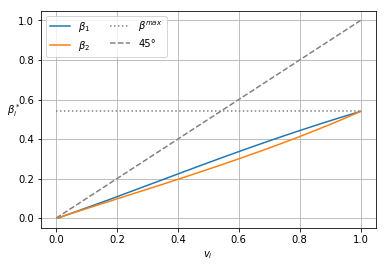

In [22]:
save = False 
    # change to 'True' if you would like to save the image 
    # (also True in beginning of section needed)

loc_image = Path(location, 'thesis_inv_bid_fct_high.png') 
    # path to save the image
b_high, v_high = diff_eq_solver(diff_eq_high) 
    # grid of inv. opt. bid fcts.
plot_strategies(b_high, v_high, loc_image, save) 
    # plot

The inverse optimal bid functions of the $\textit{low-type}$ case:

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


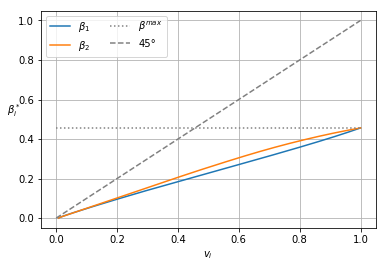

In [23]:
save = False 
    # change to 'True' if you would like to save the image 
    # (also True in beginning of section needed)

loc_image = Path(location, 'thesis_inv_bid_fct_low.png') 
    # path to save the image
b_low, v_low = diff_eq_solver(diff_eq_low) 
    # grid of inverse opt. bid fcts.
plot_strategies(b_low, v_low, loc_image, save) 
    # plot

## 2.B. Figures of plots of  one-round simulation <a name='one_round_plot'> </a>
We plot a random selection of 50 auctions and a histogram of all realized prices.

### 2.B.a. 50 auctions <a name='one_round_auction_plot'> </a>

In [24]:
def plot_auction(df, kpis, p_sp, loc_image, save):
    
    tmp = df.head(50) # only first 50 auctions
    x = tmp.index # iteration number as x-value
    
    plt.figure()
    
    plt.scatter(x, tmp['bid_one'], color='tab:blue', 
                label=r'$\beta_1$')  # bid of buyer 1
    plt.scatter(x, tmp['bid_two'], color='tab:orange',
                label=r'$\beta_2$') # bid of buyer 2
    plt.plot(x, tmp['price'], color='k', label='p') 
        # prices
    plt.plot(x, [kpis['fp']]*len(x), '--k', label=r'$\bar{p}^{FP}$')
        # mean fp
    plt.plot(x, [p_sp]*len(x), linestyle='--', color='grey', 
             label=r'$\bar{p}^{SP}$') # mean sp
    
    margin = 1 / 20 # extra margin for the interval of x- and y values 
                    # for a clearer plot
    plt.xlim(0-(len(x)*margin), len(x) + (len(x)*margin))
    plt.ylim(0-margin, 1 + margin)
    plt.xlabel('auction')
    plt.ylabel('bids & prices')
    plt.legend(ncol=2)
    
    if save is True:
        plt.savefig(loc_image)
    
    plt.show()

### 2.B.b. Histogram <a name='one_round_dist_plot'> </a>

In [25]:
def plot_auction_hist(df, sp, loc_image, save):
    
    fp = df['price'].mean()

    plt.figure()

    plt.hist(df['price'], color='tab:blue', label='$p_{FP}$')
    plt.axvline(fp, color='black', linestyle='--', 
                label=r'$\bar{p}_{FP}$')
    plt.axvline(sp, color='grey', linestyle='--', label='$E[p_{SP}]$')

    plt.xlabel('price')
    plt.ylabel('frequency')
    plt.legend()
    
    if save is True:
        plt.savefig(loc_image)  

    plt.show()

The repeated auctions and the histogram for $\textit{high-types}$:

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


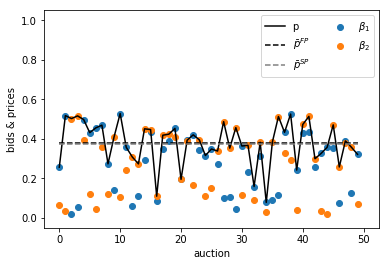

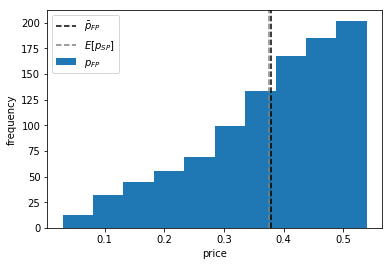

In [26]:
save = False 
    # change to 'True' if you would like to save the image 
    # (also True in beginning of section needed)

loc_image_auction = Path(location, 'thesis_fifty_auctions_high.png')
loc_image_auction_hist = Path(location, 'thesis_auctions_hist_high.png')

b_high, v_high = diff_eq_solver(diff_eq_high) 
    # grid of inverse opt. bid fcts.
tmp_high = simulate_auctions(b_high, v_high, 'high', 1000)
df_high = tmp_high[-2]
kpis_high = tmp_high[-1]
price_sp = 3/8
plot_auction(df_high, kpis_high, price_sp, loc_image_auction, save)
plot_auction_hist(df_high, price_sp, loc_image_auction_hist, save)

The repeated auctions and the histogram for $\textit{low-types}$:

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


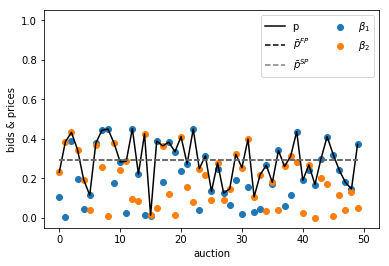

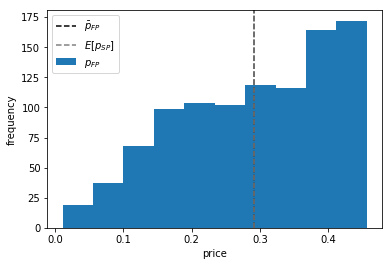

In [27]:
save = False 
    # change to 'True' if you would like to save the image 
    # (also True in beginning of section needed)

loc_image_auction = Path(location, 'thesis_fifty_auctions_low.png')
loc_image_auction_hist = Path(location, 'thesis_auctions_hist_low.png')

b_low, v_low = diff_eq_solver(diff_eq_low) 
    # grid of inverse opt. bid fcts.
tmp_low = simulate_auctions(b_low, v_low, 'low', 1000)
df_low = tmp_low[-2]
kpis_low = tmp_low[-1]
p_sp = 7/24
plot_auction(df_low, kpis_low, p_sp, loc_image_auction, save)
plot_auction_hist(df_low, p_sp, loc_image_auction_hist, save)

The diagrams present that the realized prices between auctions fluctuate quite strongly. This serves as indicator that we need to choose quite a large number of auctions to have sufficiently small standard-errors.

## 2.C. Figures of main simulation <a name='main_sim_plot'> </a>
We plot the prices of the simulation containing 100 iterations of 1000 auctions. Also we plot a histogram of the simulation's prices.

### 2.C.a. All iterations <a name='main_auction_plot'> </a>

In [28]:
def plot_simulation(prices, price_statistics, loc_image, save):
    
    plt.figure()

    x = np.arange(len(prices))
    fp = price_statistics['price_fp']
    sp = price_statistics['price_sp']
    
    plt.scatter(x, prices, color='tab:blue', label=r'$\bar{p}_{FP}$')
    plt.plot(x, [fp]*len(x), 'k--', label=r'overall $\bar{p}_{FP}$')
    plt.plot(x, [sp]*len(x), color='grey', linestyle='--', 
            label=r'$E[p_{SP}]$')

    margin = 1 / 20 # extra margin for the interval of x- and y values 
                    # for a clearer plot
    plt.xlim(0-(len(x)*margin), len(x) + (len(x)*margin))
    plt.xlabel('simulation')
    plt.ylabel('prices')
    plt.legend(ncol=3)
        
    if save is True:
        plt.savefig(loc_image)
    
    plt.show()

### 2.C.b. Histogram <a name='main_dist_plot'> </a>

In [29]:
def plot_simulation_hist(prices, price_statistics, loc_image, save):
    
    fp = price_statistics['price_fp']
    sp = price_statistics['price_sp']

    plt.figure()

    plt.hist(prices, color='tab:blue', label=r'$\bar{p}_{FP}$')
    plt.axvline(fp, color='black', linestyle='--', 
                label=r'overall $\bar{p}_{FP}$')
    plt.axvline(sp, color = 'grey', linestyle='--', 
                label=r'$E[p_{SP}]$')

    plt.xlabel('price')
    plt.ylabel('frequency')
    plt.legend()

    if save is True:
        plt.savefig(loc_image)    

    plt.show()

The simulation and histogram for $\textit{high-types}$:

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


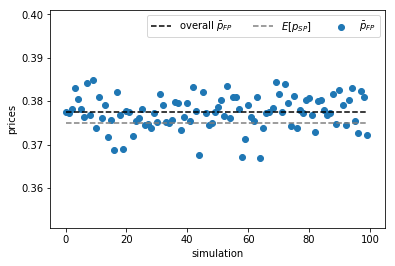

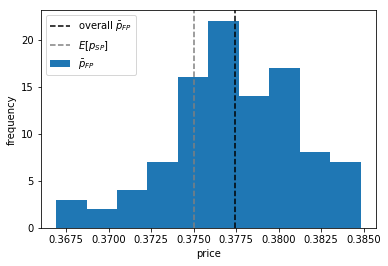

In [30]:
save = False 
    # change to 'True' if you would like to save the image 
    # (also True in beginning of section needed)

loc_image_simulation = Path(location, 'thesis_simulation_high.png')
loc_image_simulation_hist = Path(location, 'thesis_simulation_hist_high.png')

prices_high = simulate_model(diff_eq_high, 'high', 1000, 100)[0]
price_statistics_high = fct_price_statistics(prices_high, 3/8)
plot_simulation(prices_high, price_statistics_high, 
                loc_image_simulation, save)
plot_simulation_hist(prices_high, price_statistics_high, 
                     loc_image_simulation_hist, save)

The simulation and histogram for $\textit{low-types}$:

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


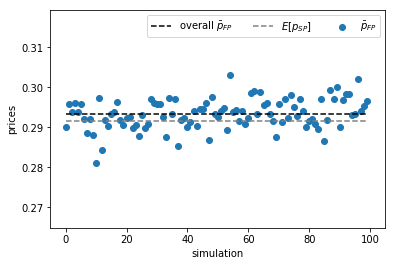

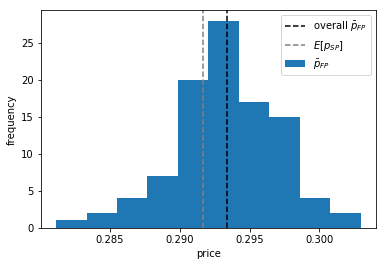

In [31]:
save = True # change to 'True' if you would like to save the image (also True in beginning of 
            # section needed)

loc_image_simulation = Path(location, 'thesis_simulation_low.png')
loc_image_simulation_hist = Path(location, 'thesis_simulation_hist_low.png')

prices_low = simulate_model(diff_eq_low, 'low', 1000, 100)[0]
price_statistics_low = fct_price_statistics(prices_low, 7/24)
plot_simulation(prices_low, price_statistics_low, 
                loc_image_simulation, save)
plot_simulation_hist(prices_low, price_statistics_low, 
                     loc_image_simulation_hist, save)

The figures underline that the average prices of the $\textit{FP}$ auction are significantly different from the prices of the $\textit{SP}$ auction.